In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from datetime import datetime
from datetime import date


font = {'size'   : 15}

matplotlib.rc('font', **font)

# Data Preprocessing

In [2]:
df_trans  = pd.read_csv('dataset/transactions.csv')
df_cdemo  = pd.read_csv('dataset/customer_demographics.csv')
df_caddr  = pd.read_csv('dataset/customer_address.csv')
df_newc   = pd.read_csv('dataset/new_customer.csv')

df_nc_details = pd.read_csv('dataset/new_customer.csv')
df_cc_details = pd.merge(df_cdemo, df_caddr, how='left', on='customer_id')

In [3]:
def DOB2Age(dob): 
    dob = str(dob).replace('/', '-')
    if dob == 'nan': return 0
    
    dt    = datetime.strptime(dob, '%Y-%m-%d')
    born  = date(dt.year, dt.month, dt.day)
    today = date.today() 
    
    try:  
        birthday = born.replace(year = today.year) 
  
    except ValueError:  
        birthday = born.replace(year = today.year, 
                  month = born.month + 1, day = 1) 
  
    if birthday > today: 
        return today.year - born.year - 1
    else: 
        return today.year - born.year 
    
def one_hot_encode_col(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)

    return df.drop([column_name], axis=1)

def check_na(df, cols=[], verbose=True):
    cols = df.columns if len(cols) == 0 else cols
    ms_dict = {col: df.loc[df[col].isna() == True, col].shape[0] for col in cols}
    
    if verbose: pprint(ms_dict)
        
    return ms_dict

In [4]:
df_train = df_cc_details.drop(columns=['first_name', 'last_name', 'default', 'country', 'address'], axis=0)

# drop transaction product_id, transaction_id

# unify the gender code
df_train['gender'] = df_train.gender.str.upper()
df_train.loc[df_train.gender.str.find('FEMA') >= 0, 'gender'] = 'F'
df_train.loc[df_train.gender.str.find('MAL') >= 0, 'gender']  = 'M'

# unify state to code
states_code = {'NEW SOUTH WALES': 'NSW',
               'QUEENSLAND'     : 'QLD',
               'VICTORIA'       : 'VIC'}

# state name to state code formating function
name2code = lambda name: states_code[name] if name in states_code.keys() else name

# fill the missing value with NSW
df_train.loc[df_train.state.isna(), 'state'] = 'NSW'

# convert the state name to upper case state code
df_train['state'] = df_train['state'].str.upper()
df_train['state'] = df_train['state'].apply(name2code)

# convert DOB to age
df_train['age'] = df_train['DOB'].apply(DOB2Age)

# clean up the job title
df_train.loc[df_train['job_title'].isna(), 'job_title'] = ''

# clean up the job category
df_train.loc[df_train['job_industry_category'].isna(), 'job_industry_category'] = ''

df_train.columns

Index(['customer_id', 'gender', 'past_3_years_bike_related_purchases', 'DOB',
       'job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'tenure', 'postcode', 'state',
       'property_valuation', 'age'],
      dtype='object')

In [5]:
def clean(df):
    # drop column
    column = ['DOB']#, 'past_3_years_bike_related_purchases']
    df = df.drop(columns=column, axis=0)
    
    # dummies
    df = one_hot_encode_col(df, 'gender')
    df = one_hot_encode_col(df, 'owns_car')
    df = one_hot_encode_col(df, 'wealth_segment')
    df = one_hot_encode_col(df, 'deceased_indicator')

    # label encoder
    df.state = states_le.transform(df.state)
    df.tenure_bin = tenure_le.transform(df.tenure_bin)
    df.postcode_bin = postcode_le.transform(df.postcode_bin)
    df.job_title = job_title_le.transform(df.job_title)
    df.job_industry_category = job_category_le.transform(df.job_industry_category)
    df.purchased_history_bin = purchased_history_le.transform(df.purchased_history_bin)
    df.property_valuation_bin = property_valuation_le.transform(df.property_valuation_bin)
    
    return df

def fill_na(df, col, filled_with='job_industry_category'):
    df_na = df.loc[df[col].isna() == True]

    for c_id, j_id in zip(df_na.customer_id, df_na[filled_with]):
        na  = df.loc[df[filled_with] == j_id, col]
        val = np.nanmedian([*na.values])
        df.loc[(df[filled_with] == j_id) & (df['customer_id'] == c_id), col] = val
        
    return df



In [6]:
df_train = fill_na(df_train, 'postcode')
df_train = fill_na(df_train, 'property_valuation', filled_with='postcode')
df_train['tenure'] = df_train['tenure'].fillna(value=int(df_train['tenure'].median()))

# bin postcode
df_train['tenure_bin'] = pd.cut(df_train['tenure'], 10)
df_train['postcode_bin'] = pd.cut(df_train['postcode'], 6)
df_train['property_valuation_bin'] = pd.cut(df_train['property_valuation'], 3)
df_train['purchased_history_bin'] = pd.cut(df_train['past_3_years_bike_related_purchases'], 6)

In [7]:
from sklearn.preprocessing import LabelEncoder

states_le = LabelEncoder().fit(df_train.state)
tenure_le = LabelEncoder().fit(df_train.tenure_bin)
postcode_le = LabelEncoder().fit(df_train.postcode_bin)
job_title_le = LabelEncoder().fit(df_train.job_title)
job_category_le = LabelEncoder().fit(df_train.job_industry_category)
purchased_history_le = LabelEncoder().fit(df_train.purchased_history_bin)
property_valuation_le = LabelEncoder().fit(df_train.property_valuation_bin)

df_train = clean(df_train)

df_train.columns

Index(['customer_id', 'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'tenure', 'postcode', 'state',
       'property_valuation', 'age', 'tenure_bin', 'postcode_bin',
       'property_valuation_bin', 'purchased_history_bin', 'gender_F',
       'gender_M', 'gender_U', 'owns_car_No', 'owns_car_Yes',
       'wealth_segment_Affluent Customer', 'wealth_segment_High Net Worth',
       'wealth_segment_Mass Customer', 'deceased_indicator_N',
       'deceased_indicator_Y'],
      dtype='object')

In [8]:
df_trans_mod = df_trans.drop(columns=['transaction_id', 'product_id', 'product_first_sold_date', 'transaction_date'])
df_trans_mod = df_trans_mod.loc[df_trans_mod['product_class'].isna() == False]

# dummies
df_trans_mod = one_hot_encode_col(df_trans_mod, 'order_status')
df_trans_mod = one_hot_encode_col(df_trans_mod, 'product_class')
df_trans_mod = one_hot_encode_col(df_trans_mod, 'product_size')
df_trans_mod = one_hot_encode_col(df_trans_mod, 'product_line')
df_trans_mod = one_hot_encode_col(df_trans_mod, 'brand')

# reformatting the price format and convert it to float
str2currency = lambda string: float(re.sub(r'[$,]', '', string))
df_trans_mod.standard_cost = df_trans_mod.standard_cost.apply(str2currency)

In [9]:
# group by
df_group = df_trans_mod.groupby('customer_id')
df_group_sum = df_group.sum().reset_index()
df_group_sum['price_variation'] = df_group_sum.standard_cost - df_group_sum.list_price 

# rename columns for better understanding
df_group_sum = df_group_sum.rename(columns={'list_price'  : 'spending',
                                            'online_order': 'nb_purchased_online'})

# merge with df_train
df_train = pd.merge(df_train, df_group_sum, how='left', on='customer_id')

# drop na rows
df_train = df_train.dropna()

## Data Exploration

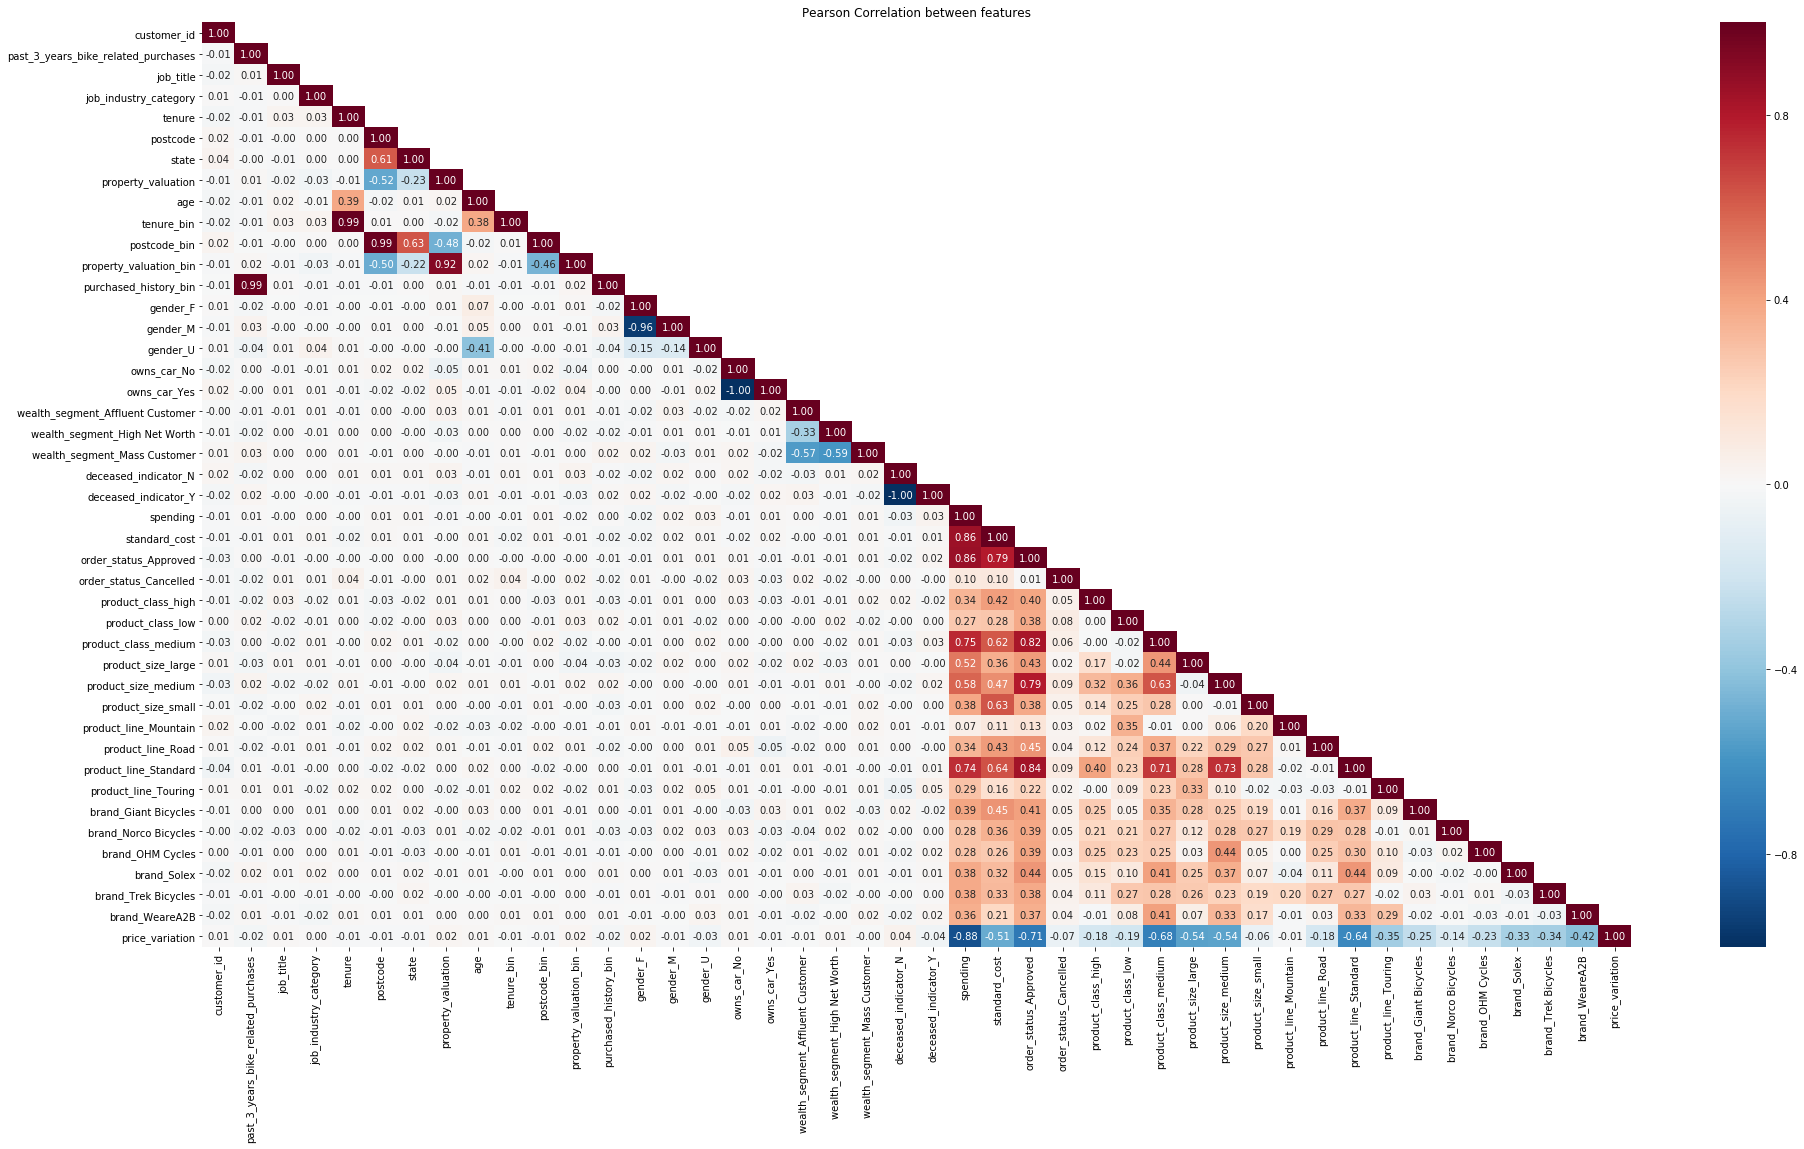

In [10]:
def plot_correlation(df):
    assert type(df) == pd.DataFrame, 'Please ensure df is a dataframe type'

    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True

    plt.figure(figsize=(32,17))
    plt.title('Pearson Correlation between features')
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r')
    plt.show()
    

plot_correlation(df_train)

### wealth segment

In [10]:
df_train.columns

Index(['customer_id', 'gender', 'past_3_years_bike_related_purchases', 'DOB',
       'job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'tenure', 'postcode', 'state',
       'property_valuation', 'age', 'purchased_history_bin'],
      dtype='object')

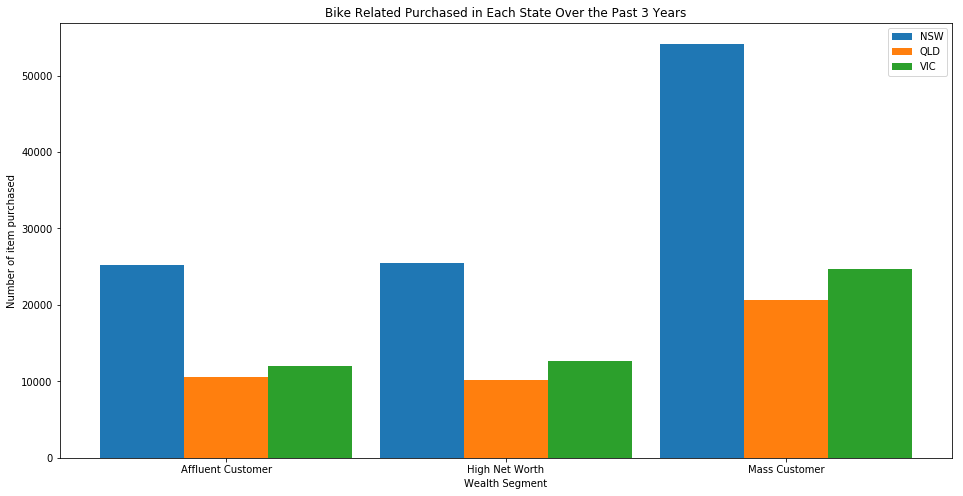

In [11]:
wealth = np.unique(df_train.wealth_segment)
states = np.unique(df_train.state)

wealth_count = {w: df_train.loc[df_train['wealth_segment'] == w, 'wealth_segment'].count() for w in wealth}
wealth_sum   = {w: [df_train.loc[
                    (df_train['wealth_segment'] == w) & \
                    (df_train['state'] == s), 
                    'past_3_years_bike_related_purchases'].sum() for s in states]
                for w in wealth}

k, c = [str(i) for i in wealth_count.keys()], [*wealth_count.values()]
s    = np.array([*wealth_sum.values()])
ind  = np.arange(3)
wid  = 0.3

plt.figure(figsize=(16,8))
plt.bar(ind  , s[:,0], wid, label=states[0])
plt.bar(ind+0.3, s[:,1], wid, label=states[1])
plt.bar(ind+0.6, s[:,2], wid, label=states[2])
plt.title('Bike Related Purchased in Each State Over the Past 3 Years')
plt.xlabel('Wealth Segment')
plt.ylabel('Number of item purchased')
plt.xticks(ind+0.3, k)
plt.legend()
plt.show()

### Job category

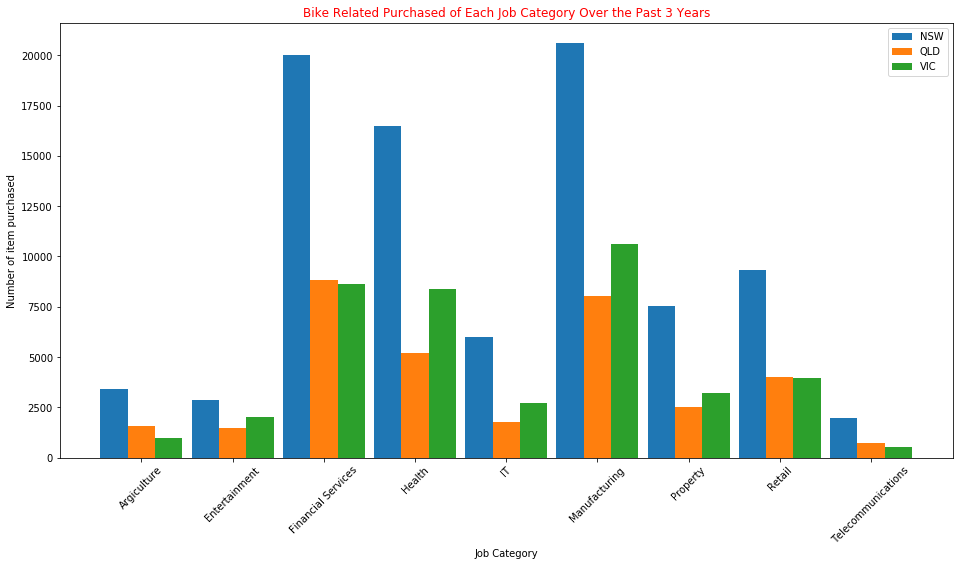

In [12]:
states         = np.unique(df_train.state)
job_categories = np.unique(df_train.job_industry_category)[1:]
job_sum        = {jc: [df_train.loc[
                    (df_train['job_industry_category'] == jc) & \
                    (df_train['state'] == s), 
                    'past_3_years_bike_related_purchases'].sum() for s in states]
                for jc in job_categories}

k, s = [str(i) for i in job_sum.keys()], np.array([*job_sum.values()])
ind  = np.arange(len(job_categories))
wid  = 0.3

plt.figure(figsize=(16,8))
plt.bar(ind    , s[:,0], wid, label=states[0])
plt.bar(ind+0.3, s[:,1], wid, label=states[1])
plt.bar(ind+0.6, s[:,2], wid, label=states[2])
plt.title('Bike Related Purchased of Each Job Category Over the Past 3 Years', color='r')
plt.xlabel('Job Category')
plt.ylabel('Number of item purchased')
plt.xticks(ind+0.3, k, rotation=45)
plt.legend()
plt.show()

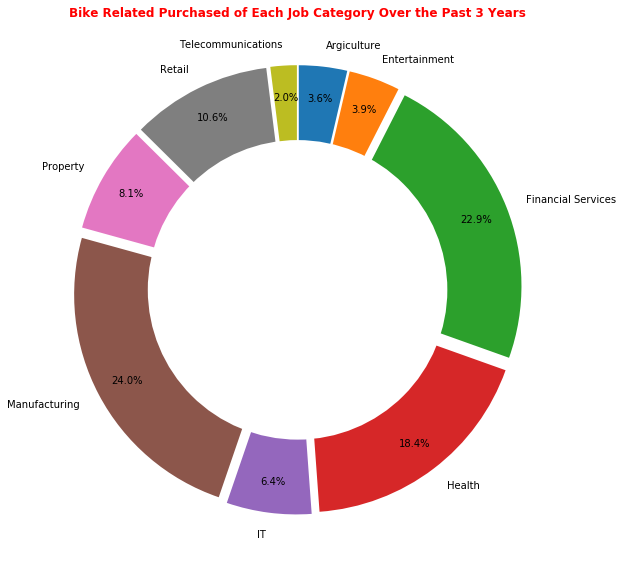

In [13]:
percentage = np.array([*job_sum.values()]).sum(axis=1)
percentage = percentage / percentage.sum() * 100
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)

plt.figure(figsize=(16,8))
plt.pie(percentage, labels=job_sum.keys(), startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode, pctdistance=0.85)
plt.title('Bike Related Purchased of Each Job Category Over the Past 3 Years', color='r', fontweight='bold')

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
# ax1.axis('equal')  
plt.tight_layout()

plt.show()

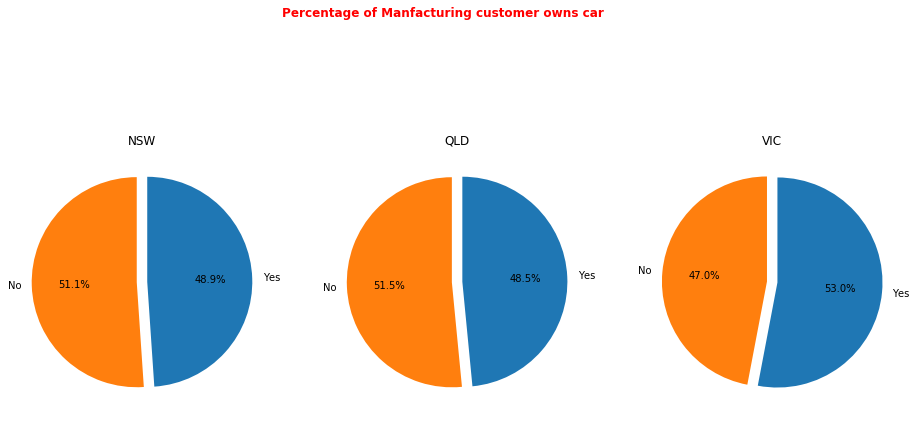

In [14]:
states = np.unique(df_train['state'])
own_cars_count = {s:df_train.loc[
                    (df_train['job_industry_category'] == 'Manufacturing') & \
                    (df_train['owns_car'] == 'Yes') & \
                    (df_train['state'] == s), 
                    'owns_car'].count()
                 for s in states}

total_count = {s:df_train.loc[
                    (df_train['job_industry_category'] == 'Manufacturing') & \
                    (df_train['state'] == s), 
                    'owns_car'].count()
                 for s in states}

owns_car_percentage = (np.array([*own_cars_count.values()]) / np.array([*total_count.values()]))

explode = (0.05,0.05)

fig = plt.figure(figsize=(16,8))
plt.title('Percentage of manufacturing customer owns a car', color='r', fontweight='bold')

plt.subplot(1,3,1)
plt.title(states[0])
plt.pie([owns_car_percentage[0], 1 - owns_car_percentage[0]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)

plt.subplot(1,3,2)
plt.title(states[1])
plt.pie([owns_car_percentage[1], 1 - owns_car_percentage[1]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)

plt.subplot(1,3,3)
plt.title(states[2])
plt.pie([owns_car_percentage[2], 1 - owns_car_percentage[2]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)


fig.suptitle('Percentage of Manfacturing customer owns car', color='r', fontweight='bold')
plt.show()




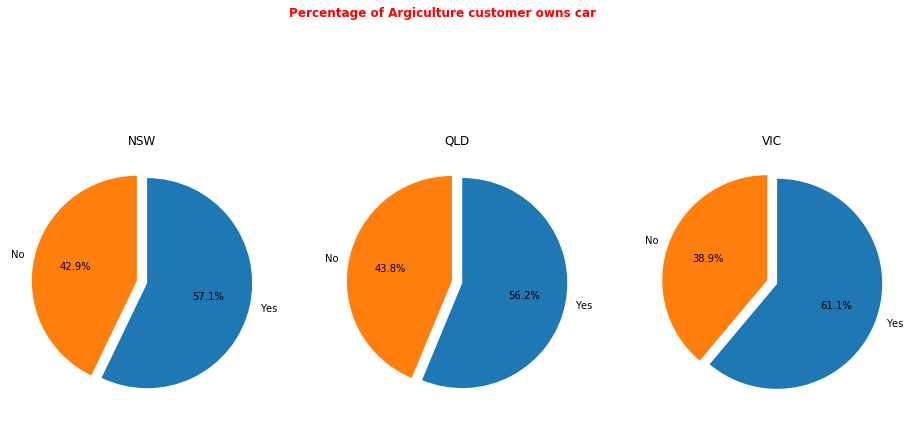

In [15]:
states = np.unique(df_train['state'])
own_cars_count = {s:df_train.loc[
                    (df_train['job_industry_category'] == 'Argiculture') & \
                    (df_train['owns_car'] == 'Yes') & \
                    (df_train['state'] == s), 
                    'owns_car'].count()
                 for s in states}

total_count = {s:df_train.loc[
                    (df_train['job_industry_category'] == 'Argiculture') & \
                    (df_train['state'] == s), 
                    'owns_car'].count()
                 for s in states}

owns_car_percentage = np.array([*own_cars_count.values()]) / np.array([*total_count.values()])

explode = (0.05,0.05)

fig = plt.figure(figsize=(16,8))
plt.title('Percentage of manufacturing customer owns a car', color='r', fontweight='bold')

plt.subplot(1,3,1)
plt.title(states[0])
plt.pie([owns_car_percentage[0], 1 - owns_car_percentage[0]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)

plt.subplot(1,3,2)
plt.title(states[1])
plt.pie([owns_car_percentage[1], 1 - owns_car_percentage[1]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)

plt.subplot(1,3,3)
plt.title(states[2])
plt.pie([owns_car_percentage[2], 1 - owns_car_percentage[2]], 
        labels=['Yes', 'No'], startangle=90, 
        counterclock=False, autopct='%1.1f%%', 
        explode=explode)

fig.suptitle('Percentage of Argiculture customer owns car', color='r', fontweight='bold')
plt.show()





### Gender

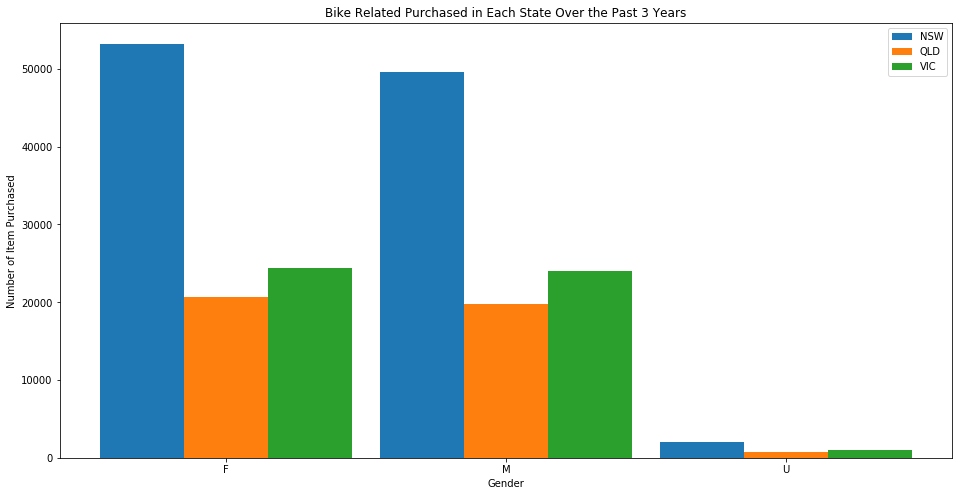

In [16]:
gender = np.unique(df_train.gender)
states = np.unique(df_train.state)
gender_count = {g: df_train.loc[
                        (df_train['gender'] == g),
                        'gender'].count() 
                for g in gender}

gender_sum   = {g: [df_train.loc[
                    (df_train['gender'] == g) & \
                    (df_train['state'] == s), 
                    'gender'].count() for s in states]
                for g in gender}

gender_purchased = {g: [df_train.loc[
                    (df_train['gender'] == g) & \
                    (df_train['state'] == s), 
                    'past_3_years_bike_related_purchases'].sum() for s in states]
                for g in gender}

k, c = [str(i) for i in gender_count.keys()], [*gender_count.values()]
s, p = np.array([*gender_sum.values()]), np.array([*gender_purchased.values()])
ind  = np.arange(3)
wid  = 0.3

# plt.figure(figsize=(16,8))
# plt.bar(ind    , s[:,0], wid, label=states[0])
# plt.bar(ind+0.3, s[:,1], wid, label=states[1])
# plt.bar(ind+0.6, s[:,2], wid, label=states[2])
# plt.title('Customer Gender count in Each State')
# plt.xlabel('State')
# plt.ylabel('Count')
# plt.xticks(ind+0.3, k)
# plt.legend()
# plt.show()

plt.figure(figsize=(16,8))
plt.bar(ind    , p[:,0], wid, label=states[0])
plt.bar(ind+0.3, p[:,1], wid, label=states[1])
plt.bar(ind+0.6, p[:,2], wid, label=states[2])
plt.title('Bike Related Purchased in Each State Over the Past 3 Years')
plt.xlabel('Gender')
plt.ylabel('Number of Item Purchased')
plt.xticks(ind+0.3, k)
plt.legend()
plt.show()

### new customer count

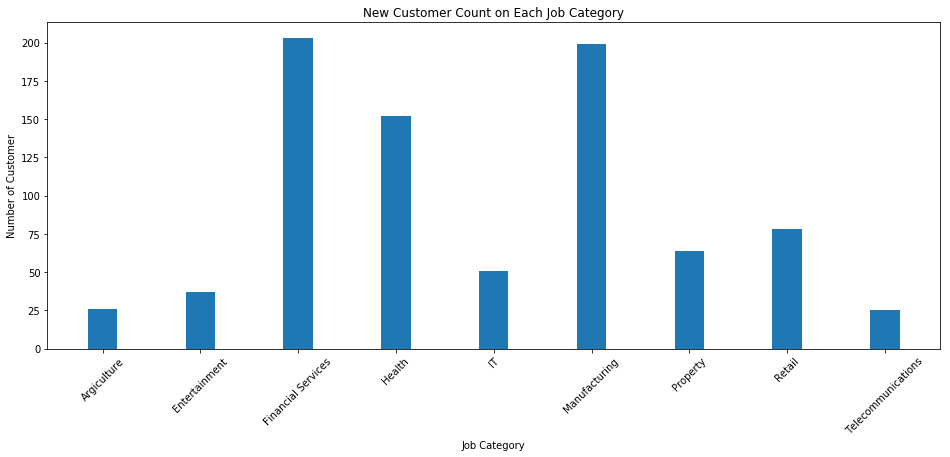

In [17]:
job_categories = np.unique(df_train.job_industry_category)[1:]
newc_count = {jc: df_newc.loc[df_newc['job_industry_category'] == jc, 'deceased_indicator'].count() for jc in job_categories}

wid = 0.3
k, c = [*newc_count.keys()], [*newc_count.values()]

plt.figure(figsize=(16,6))
plt.bar(k , c, wid, label='job_categories')
plt.title('New Customer Count on Each Job Category')
plt.xlabel('Job Category')
plt.ylabel('Number of Customer')
plt.xticks(rotation=45)
# plt.legend()
plt.show()

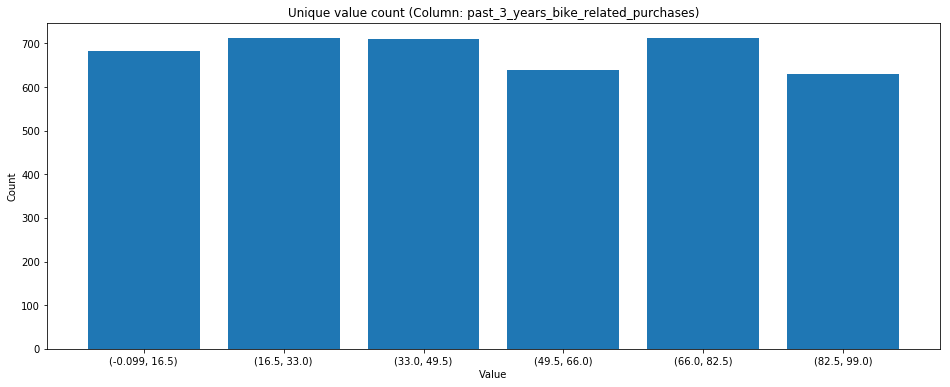

In [18]:
bins = np.unique(df_train['purchased_history_bin'])
counts = {(k.left, k.right): \
           df_train.loc[
            (df_train['past_3_years_bike_related_purchases'] >= k.left) & 
            (df_train['past_3_years_bike_related_purchases'] <= k.right), 
            'purchased_history_bin'
        ].count() for k in bins}

k, c = [str(i) for i in counts.keys()], [*counts.values()]

plt.figure(figsize=(16,6))
plt.bar(k, c)
plt.title('Unique value count (Column: {})'.format('past_3_years_bike_related_purchases'))
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

### Unique count

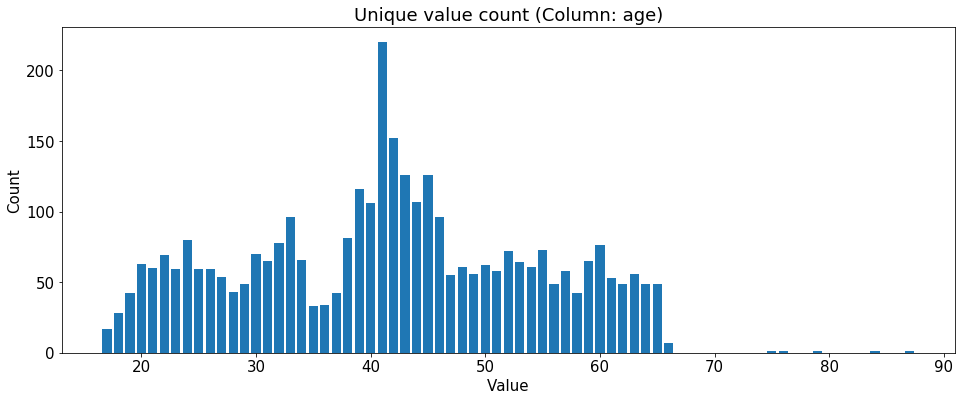

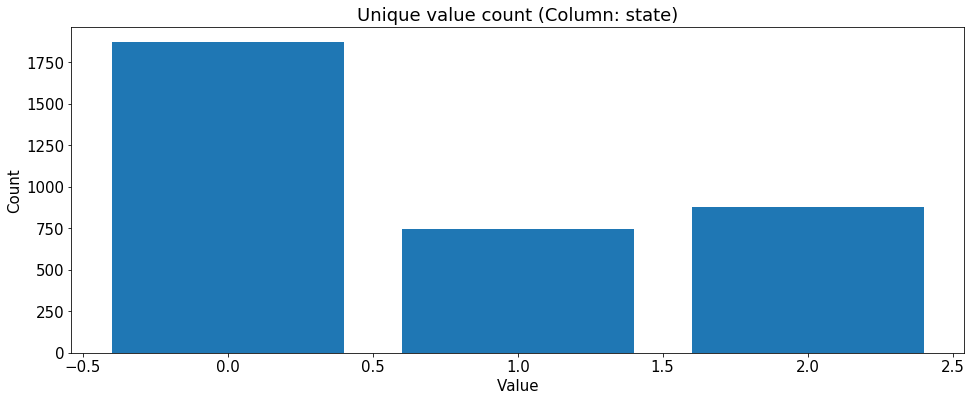

KeyError: 'tenure'

In [84]:
def unq_count(df, column):
    k, c  = np.unique(df.loc[df[column].isna() == False, column], return_counts=True)
    
    plt.figure(figsize=(16,6))
    plt.bar(k, c)
    plt.title('Unique value count (Column: {})'.format(column))
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()
    
unq_count(df_train.loc[(df_train['age'] < 100) & (df_train['age'] > 0)], 'age')
unq_count(df_train, 'state')
unq_count(df_train, 'tenure')
unq_count(df_train, 'property_valuation')

# Clustering model

In [11]:
def norm_x(df):
    for k, v in minmax.items():
        norm_func = lambda x: (x - v[0]) / (v[1] - v[0])
        df[k] = df[k].apply(norm_func)
    
    return df

def unnorm_x(df):
    for k, v in minmax.items():
        norm_func = lambda x: x * (v[1] - v[0]) + v[0]
        df[k] = df[k].apply(norm_func)
    
    return df

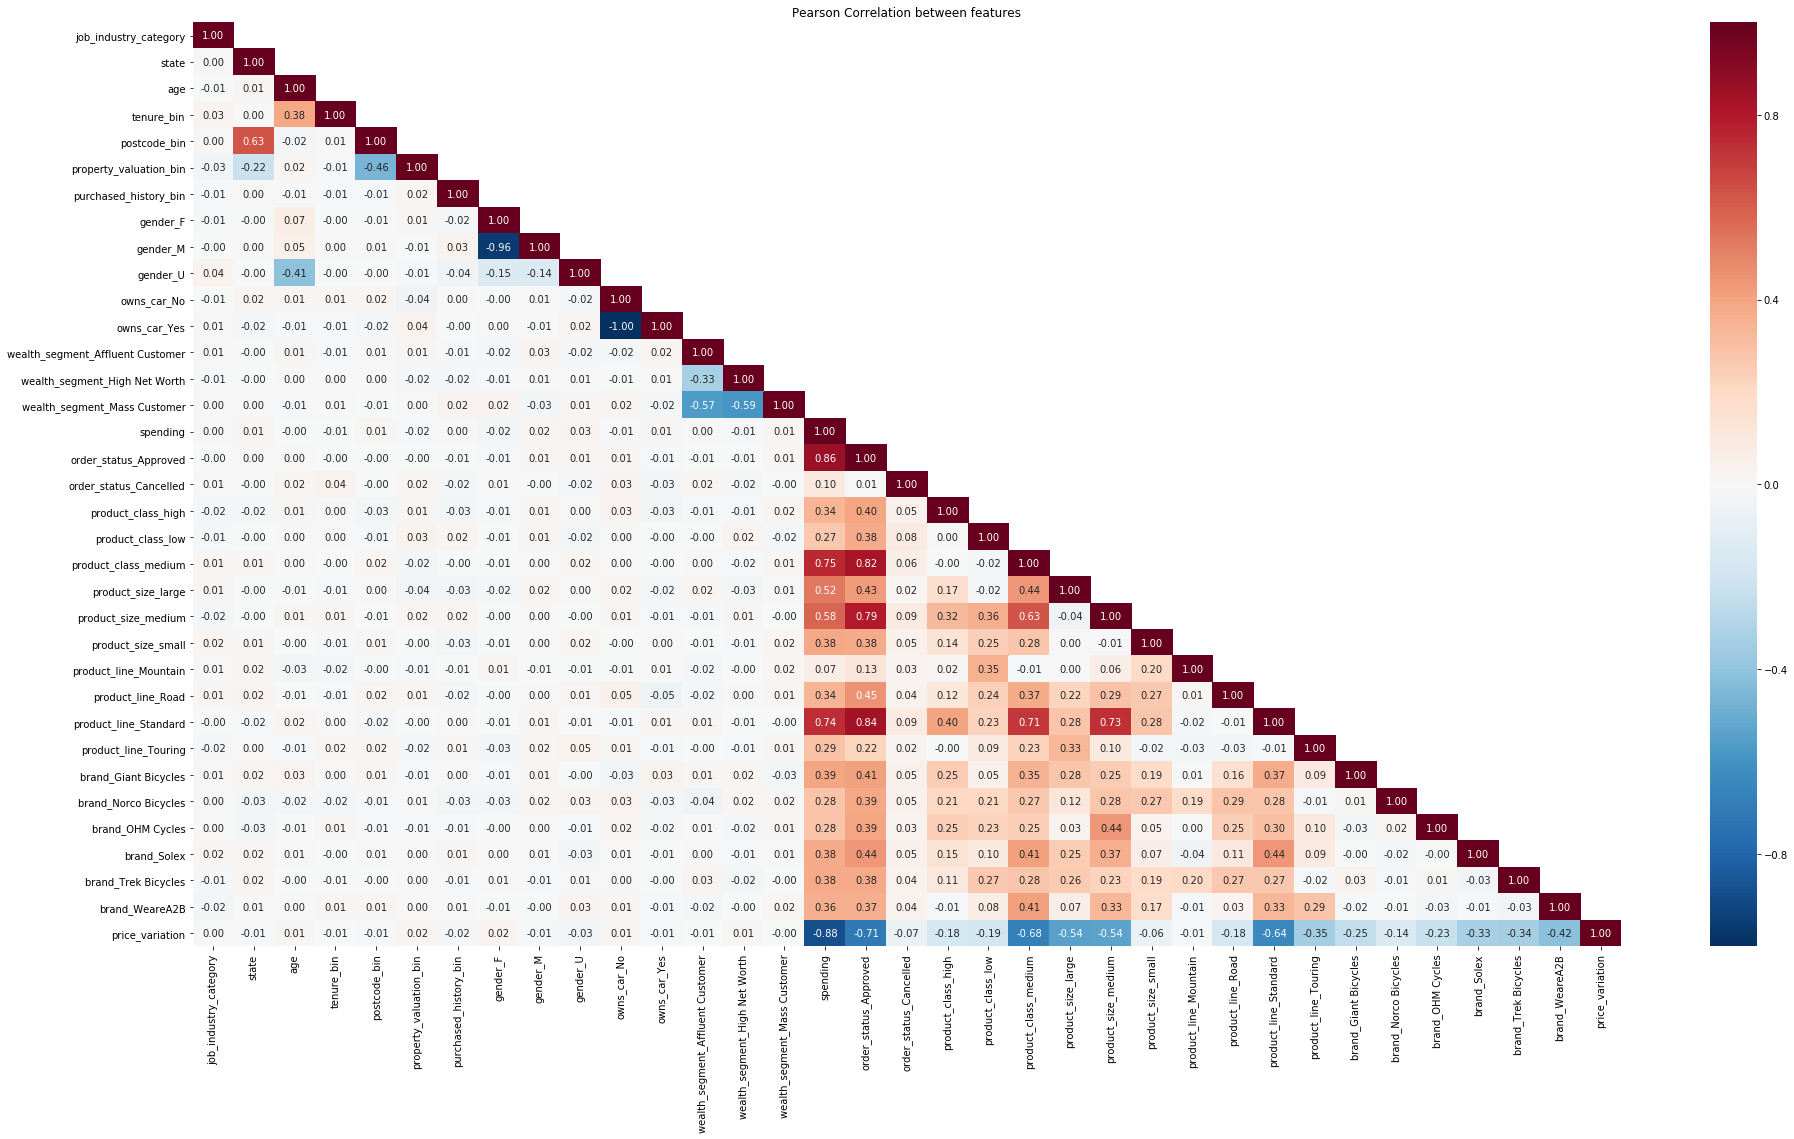

In [12]:
dp_cols=['customer_id', 'job_title', 'past_3_years_bike_related_purchases', 
         'property_valuation', 'postcode', 'tenure', 'standard_cost',
         'deceased_indicator_N', 'deceased_indicator_Y']

df_train = df_train.drop(columns=dp_cols)
minmax   = {col: (df_train[col].min(), df_train[col].max()) for col in df_train.columns}
df_train = norm_x(df_train)

plot_correlation(df_train)

In [74]:
from sklearn.cluster import KMeans

cluster_sse = []

for i in range(3, 25):
    model = KMeans(n_clusters=i, n_init=300, max_iter=3000, verbose=0, tol=1e-6, random_state=0)
    model.fit(df_train.values)
    cluster_sse.append(model.inertia_)
    
difference = np.array(cluster_sse) - np.array(cluster_sse[1:] + [0])

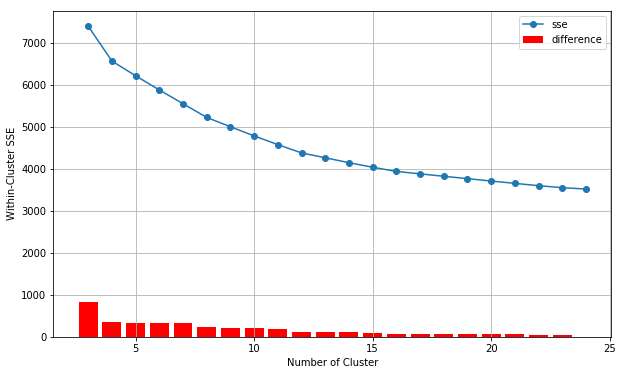

In [75]:
plt.figure(figsize=(10,6))
plt.xlabel('Number of Cluster')
plt.ylabel('Within-Cluster SSE')
plt.plot(range(3, 25), cluster_sse, marker='o', label='sse')
plt.bar(range(3, 24), difference[:-1], color='r', label='difference')
plt.legend()
plt.grid()
plt.show()

In [76]:
model = KMeans(n_clusters=4, n_init=300, max_iter=3000, verbose=0, tol=1e-6, random_state=0)
model.fit(df_train.values)

labels = set(model.labels_)
c_cluster = [model.cluster_centers_[0] * (v[1] - v[0]) + v[0] for v in minmax.values()]

df_y = unnorm_x(df_train.copy())
df_y['cluster_labels'] = [*model.labels_]
cluster = {l: df_y.loc[df_y['cluster_labels'] == l, 'cluster_labels'].count() for l in labels}

In [16]:
def cluster_monitoring(df, labels=0, columns='age'):
    df = df.loc[df['cluster_labels'] == labels]
    unq_count(df, columns)

In [17]:
df_train.columns

Index(['job_title', 'job_industry_category', 'state', 'age', 'tenure_bin',
       'postcode_bin', 'property_valuation_bin', 'purchased_history_bin',
       'gender_F', 'gender_M', 'gender_U', 'owns_car_No', 'owns_car_Yes',
       'wealth_segment_Affluent Customer', 'wealth_segment_High Net Worth',
       'wealth_segment_Mass Customer', 'spending', 'order_status_Approved',
       'order_status_Cancelled', 'product_class_high', 'product_class_low',
       'product_class_medium', 'product_size_large', 'product_size_medium',
       'product_size_small', 'product_line_Mountain', 'product_line_Road',
       'product_line_Standard', 'product_line_Touring', 'brand_Giant Bicycles',
       'brand_Norco Bicycles', 'brand_OHM Cycles', 'brand_Solex',
       'brand_Trek Bicycles', 'brand_WeareA2B', 'price_variation'],
      dtype='object')

In [18]:
{idx: job_category_le.inverse_transform([idx]) for idx in [*set(df_y['job_industry_category'])]}

{0: array([''], dtype=object),
 1: array(['Argiculture'], dtype=object),
 2: array(['Entertainment'], dtype=object),
 3: array(['Financial Services'], dtype=object),
 4: array(['Health'], dtype=object),
 5: array(['IT'], dtype=object),
 6: array(['Manufacturing'], dtype=object),
 7: array(['Property'], dtype=object),
 8: array(['Retail'], dtype=object),
 9: array(['Telecommunications'], dtype=object)}

In [78]:
c_cluster[0]

array([ 4.06228374e+00,  3.30622837e+00,  2.15389026e+00,  4.20645905e+00,
        3.06435986e+00,  5.53287197e+00,  4.32456747e+00,  9.00000000e+00,
       -6.09512441e-14, -1.87350135e-15,  9.00000000e+00, -5.49560397e-14,
        2.02422145e+00,  2.24221453e+00,  4.73356401e+00,  2.85302211e+00,
        3.56500247e+00,  2.85467128e-01,  1.31141869e+00,  1.54463668e+00,
        3.17175212e+00,  1.70069204e+00,  3.01321170e+00,  1.18858131e+00,
        3.80622837e-01,  1.81833910e+00,  2.95588235e+00,  7.39619377e-01,
        1.14335146e+00,  1.06030648e+00,  9.74480969e-01,  1.56450816e+00,
        1.55294118e+00,  1.70865052e+00,  6.67764571e+00])

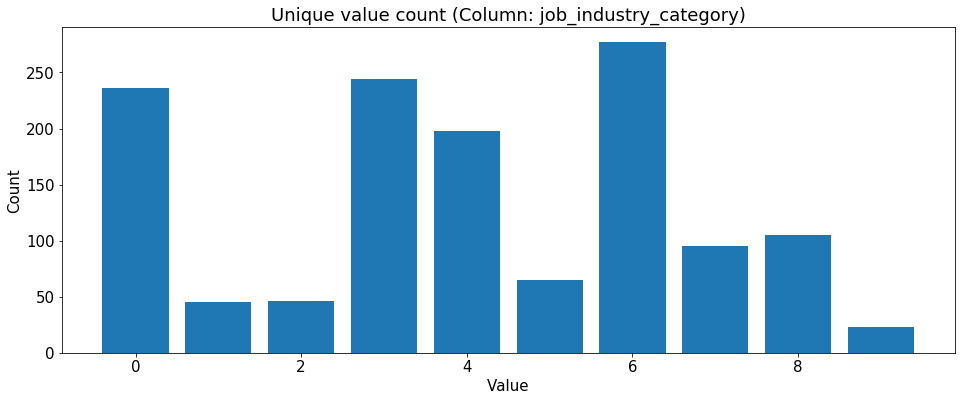

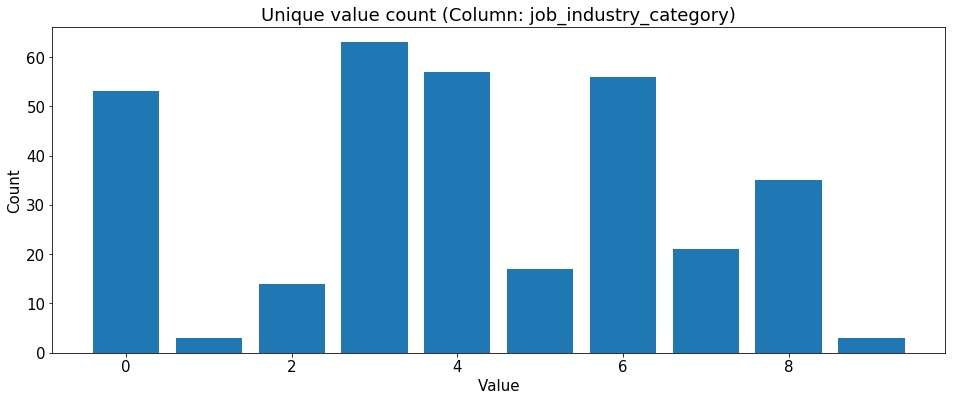

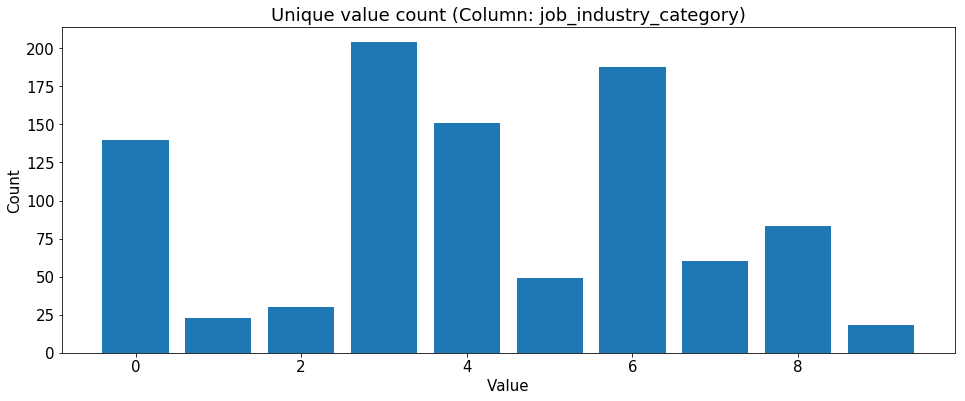

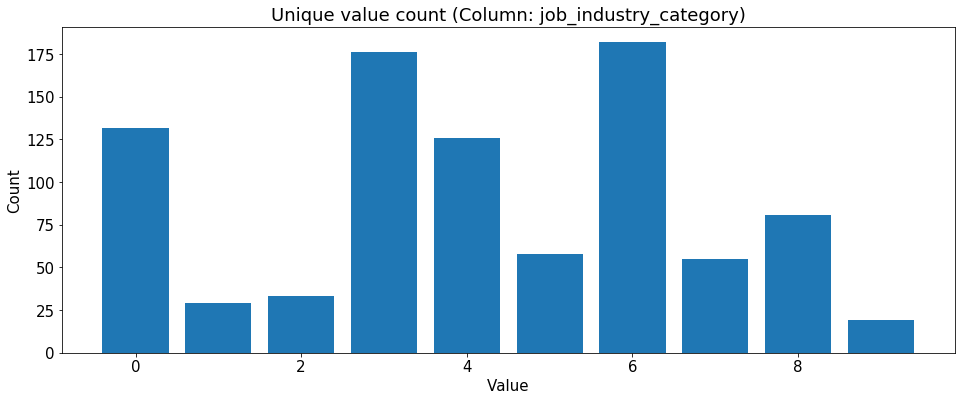

In [85]:
for l in labels:
    cluster_monitoring(df_y, labels=l, columns='job_industry_category')

### Transaction

In [21]:
df_trans  = pd.read_csv('dataset/transactions.csv')

# convert transaction date to season
Y = 2017 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  6,  1),  date(Y,  8, 31))),
           ('spring', (date(Y,  9,  1),  date(Y, 11, 30))),
           ('summer', (date(Y, 12,  1),  date(Y, 12, 31))),
           ('summer', (date(Y,  1,  1),  date(Y,  2, 28))),
           ('autumn', (date(Y,  3,  1),  date(Y,  5, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

dt_transform = lambda string: datetime.strptime(string, '%Y/%m/%d')

df_trans['transaction_date'] = df_trans.transaction_date.apply(dt_transform)
df_trans['season'] = df_trans.transaction_date.apply(get_season)

(array(['autumn', 'spring', 'summer', 'winter'], dtype=object), array([4996, 5008, 4949, 5047]))


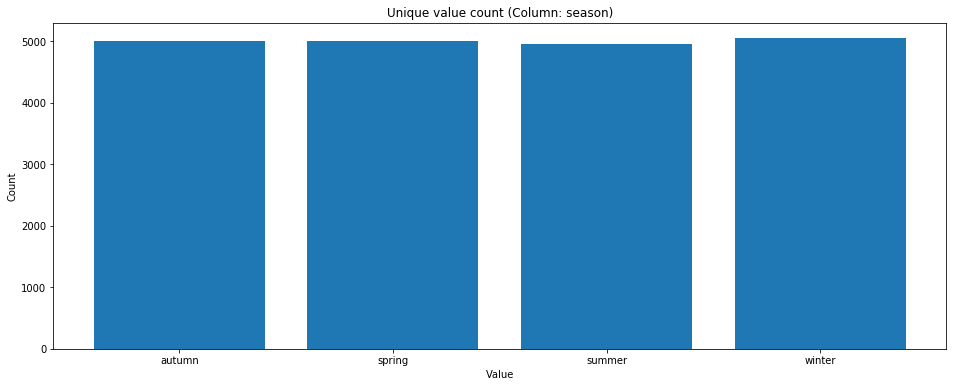

In [22]:
print(np.unique(df_trans.season, return_counts=True))
unq_count(df_trans, 'season')

In [23]:
len(np.unique(df_train.customer_id)), len(np.unique(df_trans.customer_id))

(4000, 3494)